In [1]:
import networkx as nx
import numpy as np
import requests as r
import pandas as pd
from sodapy import Socrata

Data from : https://data.cityofnewyork.us/Transportation/Automated-Traffic-Volume-Counts/7ym2-wayt

CSV from: https://data.cityofnewyork.us/resource/7ym2-wayt.csv

In [6]:
client = Socrata("data.cityofnewyork.us", None)
# results = client.get_all("7ym2-wayt") to get all of the data (this will take a while)
results = client.get("7ym2-wayt", limit=10000000)
results_df = pd.DataFrame.from_records(results)

In [7]:
results_df.head()

,requestid,boro,yr,m,d,hh,mm,vol,segmentid,wktgeom,street,fromst,tost,direction
0,1100,Staten Island,2011,10,14,10,45,102,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
1,1100,Staten Island,2011,10,14,11,0,110,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
2,1100,Staten Island,2011,10,14,11,15,101,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
3,1100,Staten Island,2011,10,14,11,30,112,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
4,1100,Staten Island,2011,10,14,11,45,94,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB


In [8]:
results_df["date"] = results_df["yr"] + "_" + results_df["m"] + "_" + results_df["d"] + "_" + results_df["hh"] + "_" + results_df["mm"] 

We make a graph of the NYC network with the Nodes as the to and from streets, and the edges between those nodes as the traffic flow. One graph will represent the state of traffic of the city at a single time step (YYYY/MM/DD/HH/mm).

In [12]:
counts = results_df.groupby(["date"], as_index=False).count()

In [16]:
counts

,date,requestid,boro,yr,m,d,hh,mm,vol,segmentid,wktgeom,street,fromst,tost,direction
0,2000_1_10_0_0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2000_1_10_0_15,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2000_1_10_0_30,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2000_1_10_0_45,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2000_1_10_10_0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201120,2016_8_27_7_30,1,1,1,1,1,1,1,1,1,1,1,1,1,1
201121,2016_8_27_7_45,1,1,1,1,1,1,1,1,1,1,1,1,1,1
201122,2016_8_27_8_0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
201123,2016_8_27_8_15,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [22]:
counts[counts["boro"]==542]

,date,requestid,boro,yr,m,d,hh,mm,vol,segmentid,wktgeom,street,fromst,tost,direction
150912,2013_10_26_10_0,542,542,542,542,542,542,542,542,542,542,542,542,542,542
150914,2013_10_26_10_30,542,542,542,542,542,542,542,542,542,542,542,542,542,542
150916,2013_10_26_11_0,542,542,542,542,542,542,542,542,542,542,542,542,542,542
150918,2013_10_26_11_30,542,542,542,542,542,542,542,542,542,542,542,542,542,542
150920,2013_10_26_12_0,542,542,542,542,542,542,542,542,542,542,542,542,542,542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151090,2013_10_27_7_30,542,542,542,542,542,542,542,542,542,542,542,542,542,542
151092,2013_10_27_8_0,542,542,542,542,542,542,542,542,542,542,542,542,542,542
151094,2013_10_27_8_30,542,542,542,542,542,542,542,542,542,542,542,542,542,542
151096,2013_10_27_9_0,542,542,542,542,542,542,542,542,542,542,542,542,542,542


In [54]:
def make_graph_for_time(date):
       G = nx.DiGraph()
       for row in results_df[results_df["date"]==date].iterrows():
              r = row[1]
              street = r["street"]
              to_street = r["tost"]
              from_street = r["fromst"]
              weight = r["vol"]
              
              G.add_weighted_edges_from([(f"{street}/{to_street}", f"{street}/{from_street}", weight)])
       return G


above, the nodes are the interesections and the edges are the traffic flow sbetween those intersections. We instead need the nodes to be the traffic segments themselves, and the edges will be a 1 if they are close and a 0 if they are not. 

The nodes themselves will represent a traffic sensor, so the node embedding will contain the traffic flow. \
We transform the graph above so that nodes are only connected if they are adjacent and their directions match. see ethans image

In [55]:
date = "2013_10_27_9_30"
G = make_graph_for_time(date)

In [56]:
print(len(G.nodes), len(G.edges))


419 287


ValueError: could not convert string to float: 'EDISON AV'

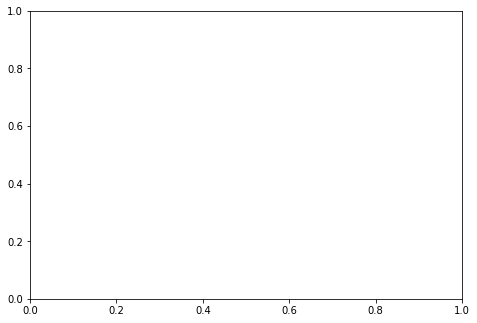

In [61]:
nx.draw(G)